In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import numpy as np
from sklearn.utils import shuffle
import pandas as pd

import h5py
import os
import shutil

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# 数据处理

In [2]:
from tqdm import tqdm
import cv2

np.random.seed(2017)

n = 24962
X = np.zeros((n, 299, 299, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

train_cat2 = os.listdir("train2/cat")
train_dog2 = os.listdir("train2/dog")

i = 0
for filename in train_cat2:
    X[i] = cv2.resize(cv2.imread('train/%s' % filename), (299, 299))
    y[i] = 0
    i += 1
for filename in train_dog2:
    X[i] = cv2.resize(cv2.imread('train/%s' % filename), (299, 299))
    y[i] = 1
    i += 1

In [3]:
m = 12500
X_test = np.zeros((m, 299, 299, 3), dtype=np.uint8)

test_file = os.listdir("test")
j = 0
for filename in test_file:
    X_test[j] = cv2.resize(cv2.imread('test/%s' % filename), (299, 299))
    j += 1

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# Xception模型

In [5]:
base_model = Xception(input_tensor=Lambda(xception.preprocess_input)(Input((299, 299, 3))), weights='imagenet', include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)
model.load_weights('xception_weights_3.h5')

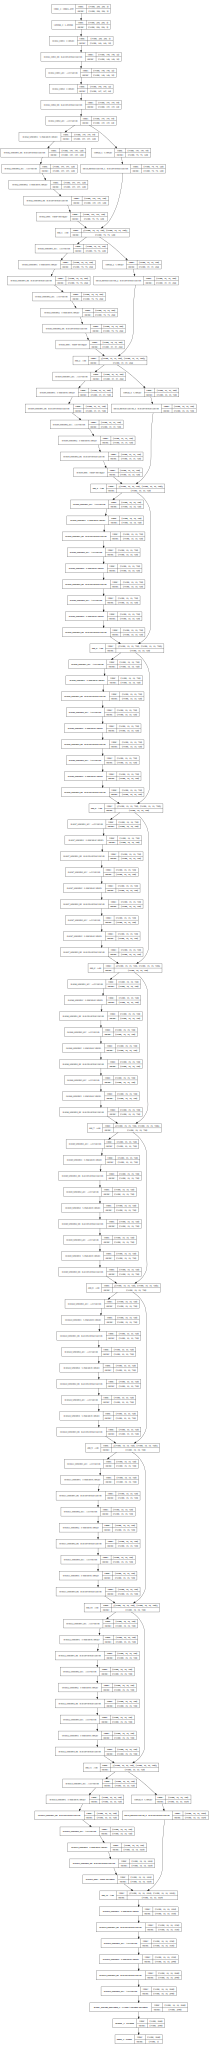

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
xception_model = Model(model.input, model.layers[-3].output, name='Xception')
inputs = Input((299, 299, 3))
x = inputs
x = xception_model(x)
xception_model = Model(inputs, x)

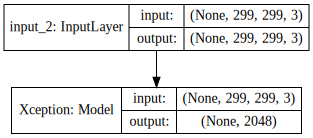

In [8]:
SVG(model_to_dot(xception_model, show_shapes=True).create(prog='dot', format='svg'))

# InceptionResNetv2模型

In [ ]:
base_model = Xception(input_tensor=Lambda(inception_resnet_v2.preprocess_input)(Input((299, 299, 3))), weights='imagenet', include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)
model.load_weights('inceptionresnetv2_weights_3.h5')

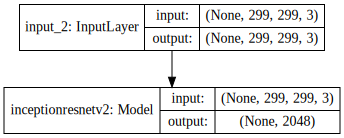

In [9]:
inception_resnet_model = Model(model.input, model.layers[-3].output, name='inceptionresnetv2')
x = inputs
x = inception_resnet_model(x)
inception_resnet_model = Model(inputs, x)
SVG(model_to_dot(inception_resnet_model, show_shapes=True).create(prog='dot', format='svg'))

# 融合

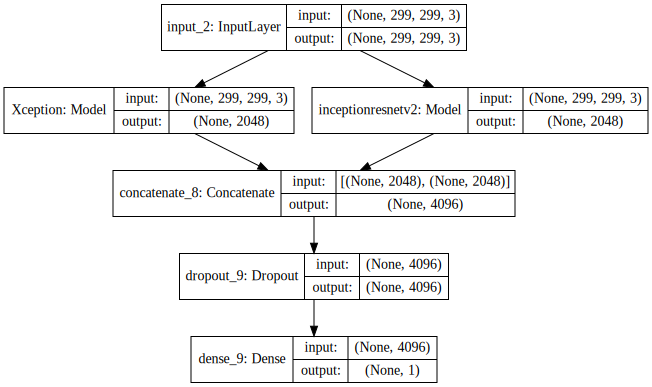

In [44]:
# for layers in xception_model.layers:
#     layers.trainable = False
# for layers in inception_resnet_model.layers:
#     layers.trainable = False

x = concatenate([xception_model.output,inception_resnet_model.output], axis=1)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
merge_model = Model(inputs, x)
SVG(model_to_dot(merge_model, show_shapes=True).create(prog='dot', format='svg'))

In [45]:
for i in range(len(merge_model.layers)):
    print(i,merge_model.layers[i].name)

0 input_2
1 Xception
2 inceptionresnetv2
3 concatenate_8
4 dropout_9
5 dense_9


In [46]:
merge_model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
merge_model.fit(X_train, y_train, batch_size=16, epochs=2, validation_data=(X_valid, y_valid))

Train on 19969 samples, validate on 4993 samples
Epoch 1/2
19969/19969 [==============================] - 515s 26ms/step - loss: 0.0062 - acc: 0.9982 - val_loss: 0.5228 - val_acc: 0.9527
Epoch 2/2
19969/19969 [==============================] - 515s 26ms/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.6907 - val_acc: 0.5063


In [49]:
y_pred = merge_model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)
df = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_file):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('merge_predict_4.csv', index=None)
df.head(2)

12500/12500 [==============================] - 97s 8ms/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.501269
1,2,0.501117
